In [48]:
# -----------------------------
# Student Performance Analysis
# UCI Dataset: student-mat.csv / student-por.csv
# Parts A–F Complete Workflow
# GROUP 3 WORK
# -----------------------------

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [26]:
# Load dataset (use both files or one)
mat_df = pd.read_csv('student-mat.csv', sep=';')
por_df = pd.read_csv('student-por.csv', sep=';')

# Add subject label
mat_df['subject'] = 'math'
por_df['subject'] = 'portuguese'

# Combine datasets
df = pd.concat([mat_df, por_df], axis=0).reset_index(drop=True)

print("Combined dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Combined dataset shape: (1044, 34)

First few rows:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  freetime goout  Dalc  Walc  health absences  G1  G2  G3 subject  
0        3     4     1     1       3        6   5   6   6    math  
1        3     3     1     1       3        4   5   5   6    math  
2        3     2     2     3       3       10   7   8  10    math  
3        2     2     1     1       5        2  15  14  15    math  
4        3     2     1     2       5        4   6  10  10    math  

[5 rows x 34 columns]


In [27]:
# Inspect data types and missing values
print("\nData info:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))


Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non-null   object
 

In [28]:
# Identify categorical and numeric columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

grade_cols = ['G1', 'G2', 'G3']
num_non_grade = [c for c in num_cols if c not in grade_cols]

print(f"Categorical columns: {cat_cols}")
print(f"Numeric non-grade columns: {num_non_grade}")

Categorical columns: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'subject']
Numeric non-grade columns: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


In [29]:
# Handle missing values (if any)
for col in df.columns:
    if df[col].dtype == 'O':  # Object type → fill with mode
        df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'unknown')
    else:  # Numeric → fill with median
        df[col] = df[col].fillna(df[col].median())

In [30]:
# One-hot encode categorical variables
df_enc = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Scale non-grade numeric features
scaler = StandardScaler()
df_enc[num_non_grade] = scaler.fit_transform(df_enc[num_non_grade])

print("Final encoded/scaled shape:", df_enc.shape)
df_enc.head()

Final encoded/scaled shape: (1044, 43)


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,subject_portuguese
0,1.027889,1.242077,1.466302,0.652210,0.035606,-0.403106,0.068788,-0.195099,0.732511,-0.542374,...,False,True,False,False,False,True,True,False,False,False
1,0.221035,-1.426089,-1.262431,-0.715074,0.035606,-0.403106,1.140653,-0.195099,-0.135527,-0.542374,...,False,False,True,False,False,False,True,True,False,False
2,-1.392674,-1.426089,-1.262431,-0.715074,0.035606,4.171268,0.068788,-0.195099,-1.003566,0.554987,...,False,True,False,True,False,True,True,True,False,False
3,-1.392674,1.242077,-0.352853,-0.715074,1.234713,-0.403106,-1.003076,-1.165019,-1.003566,-0.542374,...,False,False,True,True,True,True,True,True,True,False
4,-0.585820,0.352689,0.556724,-0.715074,0.035606,-0.403106,0.068788,-0.195099,-1.003566,-0.542374,...,False,False,True,True,False,True,True,False,False,False


In [31]:
# PART B

In [32]:
# Descriptive stats for key variables
print("Descriptive statistics for grades and study time:")
print(df[['G1', 'G2', 'G3', 'studytime', 'absences']].describe())

Descriptive statistics for grades and study time:
                G1           G2           G3    studytime     absences
count  1044.000000  1044.000000  1044.000000  1044.000000  1044.000000
mean     11.213602    11.246169    11.341954     1.970307     4.434866
std       2.983394     3.285071     3.864796     0.834353     6.210017
min       0.000000     0.000000     0.000000     1.000000     0.000000
25%       9.000000     9.000000    10.000000     1.000000     0.000000
50%      11.000000    11.000000    11.000000     2.000000     2.000000
75%      13.000000    13.000000    14.000000     2.000000     6.000000
max      19.000000    19.000000    20.000000     4.000000    75.000000


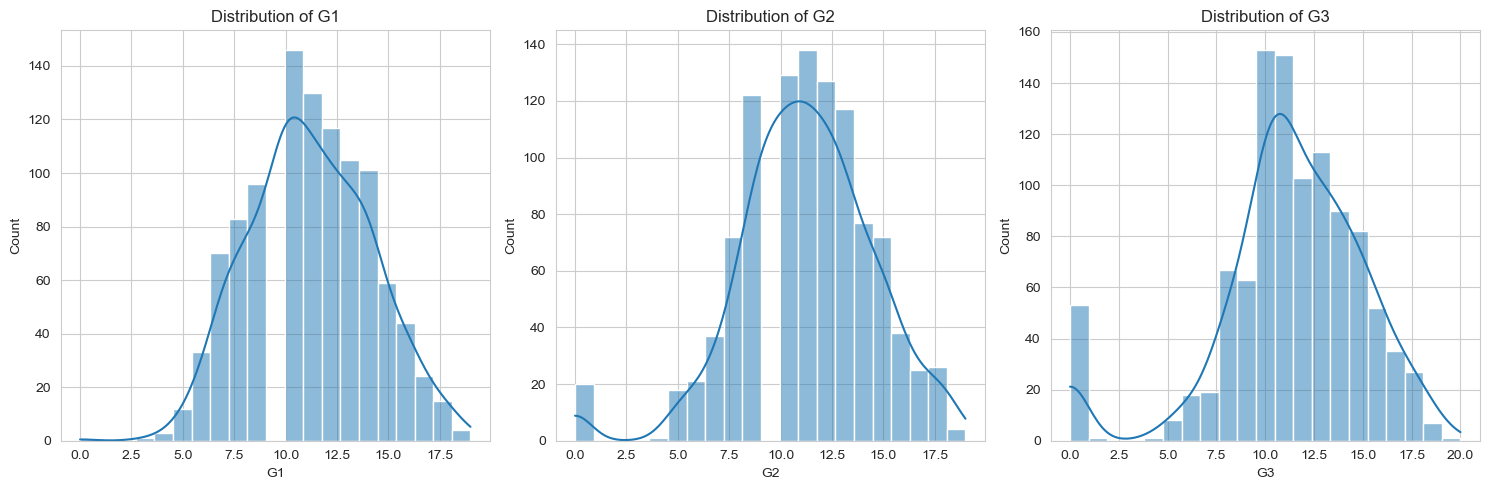

In [33]:
# Histograms for G1, G2, G3
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(['G1', 'G2', 'G3']):
    sns.histplot(df[col], kde=True, bins=21, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

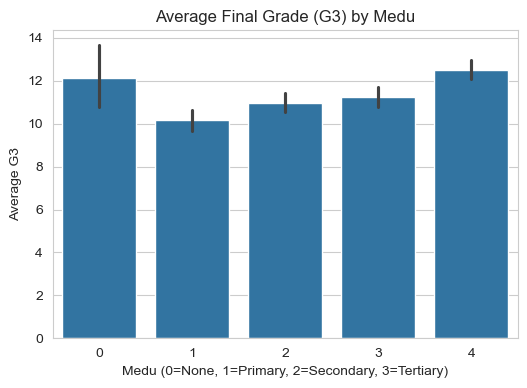

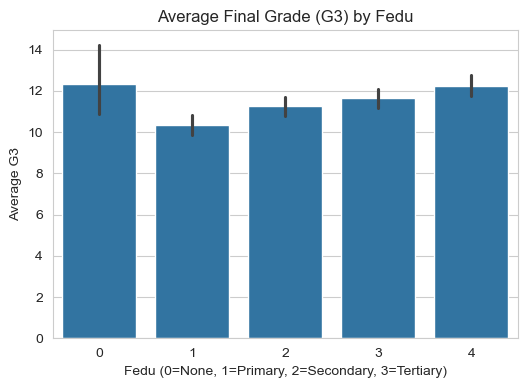

In [34]:
# Bar chart: Parental education vs average G3
par_cols = ['Medu', 'Fedu']
for pc in par_cols:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=df, x=pc, y='G3', estimator=np.mean, ci=95)
    plt.title(f'Average Final Grade (G3) by {pc}')
    plt.xlabel(f"{pc} (0=None, 1=Primary, 2=Secondary, 3=Tertiary)")
    plt.ylabel("Average G3")
    plt.show()
    

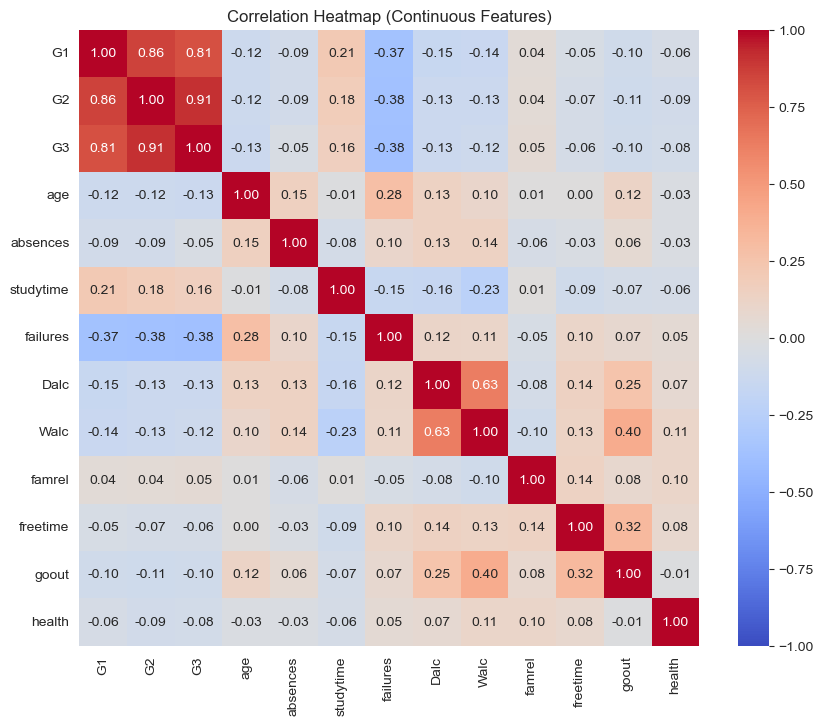

Top correlations with G3:
G3           1.000000
G2           0.910743
G1           0.809142
studytime    0.161629
famrel       0.054461
absences    -0.045671
freetime    -0.064890
health      -0.080079
goout       -0.097877
Walc        -0.115740
age         -0.125282
Dalc        -0.129642
failures    -0.383145
Name: G3, dtype: float64


In [35]:
# Correlation heatmap
cont_cols = ['G1', 'G2', 'G3', 'age', 'absences', 'studytime', 'failures', 'Dalc', 'Walc', 'famrel', 'freetime', 'goout', 'health']
corr = df[cont_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Continuous Features)')
plt.show()

print("Top correlations with G3:")
print(corr['G3'].sort_values(ascending=False))

In [36]:
# PART C

In [37]:
# Create new features
df['G12_avg'] = (df['G1'] + df['G2']) / 2.0
df['pass'] = (df['G3'] >= 10).astype(int)
df['study_abs'] = df['studytime'] * df['absences']
df['fail_abs'] = df['failures'] * df['absences']

print("New features created:")
print(df[['G12_avg', 'pass', 'study_abs', 'fail_abs']].head())

New features created:
   G12_avg  pass  study_abs  fail_abs
0      5.5     0         12         0
1      5.0     0          8         0
2      7.5     1         20        30
3     14.5     1          6         0
4      8.0     1          8         0


In [38]:
# Re-encode with new features
df_fe = df.copy()
cat_cols_fe = df_fe.select_dtypes(include=['object']).columns.tolist()
df_fe_enc = pd.get_dummies(df_fe, columns=cat_cols_fe, drop_first=True)

# Scale non-grade numeric features (excluding G1, G2, G3, G12_avg, pass)
num_cols_fe = df_fe_enc.select_dtypes(include=['int64', 'float64']).columns.tolist()
to_scale = [c for c in num_cols_fe if c not in ['G1', 'G2', 'G3', 'G12_avg', 'pass']]
scaler2 = StandardScaler()
df_fe_enc[to_scale] = scaler2.fit_transform(df_fe_enc[to_scale])

print("Final feature-engineered shape:", df_fe_enc.shape)

Final feature-engineered shape: (1044, 47)


In [39]:
# PART D

ANOVA Result: F-statistic = 10.374, p-value = 9.92e-07
Study time has a significant effect on final grade.


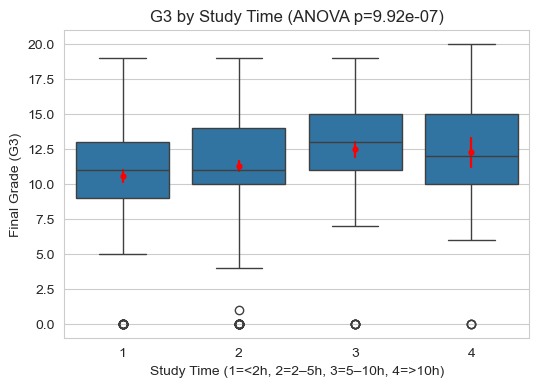

In [40]:
# ANOVA: Does study time affect G3?
groups = [df[df['studytime'] == k]['G3'] for k in sorted(df['studytime'].unique())]
f_stat, p_val = stats.f_oneway(*groups)

print(f"ANOVA Result: F-statistic = {f_stat:.3f}, p-value = {p_val:.4g}")
if p_val < 0.05:
    print("Study time has a significant effect on final grade.")
else:
    print("No significant effect.")

# Boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='studytime', y='G3')
sns.pointplot(data=df, x='studytime', y='G3', color='red', errorbar='ci', join=False, scale=0.6)
plt.title(f"G3 by Study Time (ANOVA p={p_val:.4g})")
plt.xlabel("Study Time (1=<2h, 2=2–5h, 3=5–10h, 4=>10h)")
plt.ylabel("Final Grade (G3)")
plt.show()

Chi-Square Test: chi2 = 3.182, p-value = 0.07444
No significant association.


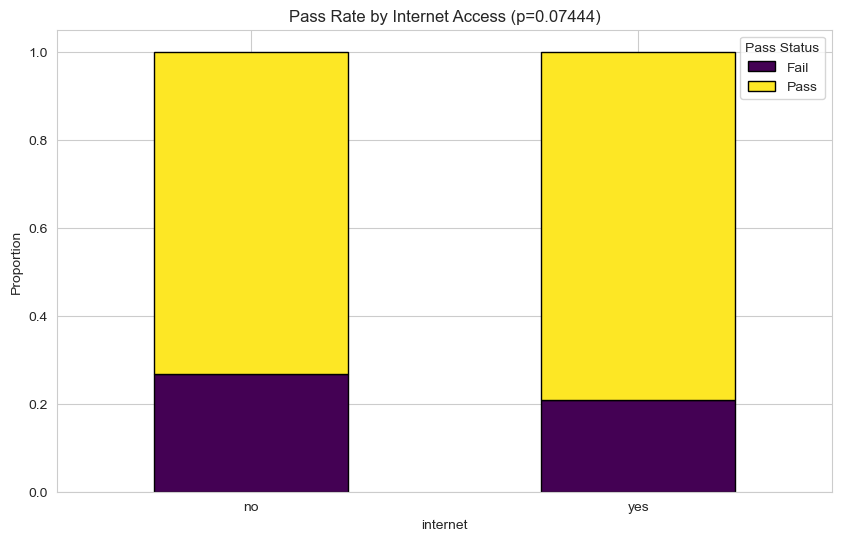

In [41]:
# Chi-square test: Internet access vs Pass/Fail
ct = pd.crosstab(df['internet'], df['pass'])
chi2_stat, p_val_chi2, dof, expected = stats.chi2_contingency(ct)

print(f"Chi-Square Test: chi2 = {chi2_stat:.3f}, p-value = {p_val_chi2:.4g}")
if p_val_chi2 < 0.05:
    print("Significant association between internet access and pass/fail.")
else:
    print("No significant association.")

# Stacked bar chart
prop = ct.div(ct.sum(axis=1), axis=0)
prop.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='black')
plt.ylabel("Proportion")
plt.title(f"Pass Rate by Internet Access (p={p_val_chi2:.4g})")
plt.xticks(rotation=0)
plt.legend(title="Pass Status", labels=["Fail", "Pass"])
plt.show()

In [42]:
# PART E

In [43]:
# Define features and target
X = df_fe_enc.drop(['G3', 'pass'], axis=1)  # Keep all engineered features
y = df_fe_enc['pass']

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train models
dt_model = DecisionTreeClassifier(random_state=42)
lr_model = LogisticRegression(random_state=42, max_iter=1000)

dt_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

# Predictions
dt_pred = dt_model.predict(X_test)
lr_pred = lr_model.predict(X_test)
dt_proba = dt_model.predict_proba(X_test)[:, 1]
lr_proba = lr_model.predict_proba(X_test)[:, 1]

In [44]:
# Evaluation function
def evaluate_model(y_true, y_pred, y_proba, name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"AUC: {auc:.3f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    return acc, prec, rec, f1, auc

dt_metrics = evaluate_model(y_test, dt_pred, dt_proba, "Decision Tree")
lr_metrics = evaluate_model(y_test, lr_pred, lr_proba, "Logistic Regression")


=== Decision Tree ===
Accuracy: 0.876
Precision: 0.931
Recall: 0.908
F1-Score: 0.919
AUC: 0.834

Confusion Matrix:
[[ 35  11]
 [ 15 148]]

=== Logistic Regression ===
Accuracy: 0.919
Precision: 0.956
Recall: 0.939
F1-Score: 0.947
AUC: 0.959

Confusion Matrix:
[[ 39   7]
 [ 10 153]]


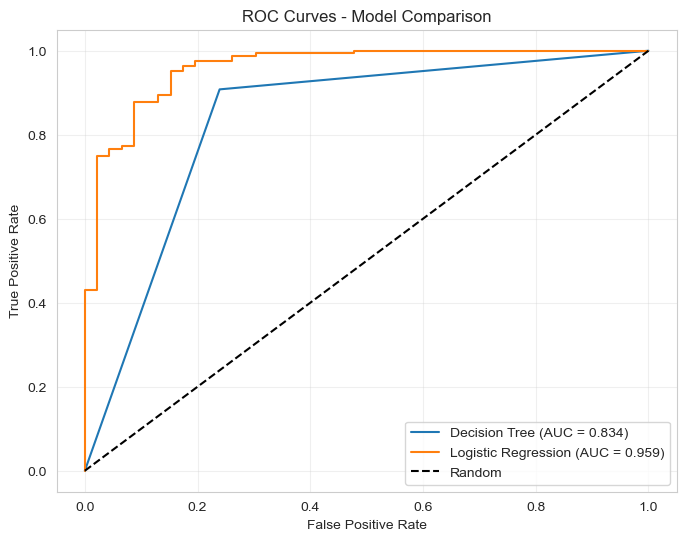

In [45]:
# ROC Curve
plt.figure(figsize=(8, 6))
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_proba)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)

plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {dt_metrics[4]:.3f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_metrics[4]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [46]:
# Multiple runs for mean ± std
n_runs = 5
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
dt_scores = {m: [] for m in metrics}
lr_scores = {m: [] for m in metrics}

for i in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i, stratify=y)
    
    dt = DecisionTreeClassifier(random_state=i).fit(X_train, y_train)
    lr = LogisticRegression(random_state=i, max_iter=1000).fit(X_train, y_train)
    
    dt_p = dt.predict(X_test)
    lr_p = lr.predict(X_test)
    dt_pr = dt.predict_proba(X_test)[:, 1]
    lr_pr = lr.predict_proba(X_test)[:, 1]
    
    dt_scores['accuracy'].append(accuracy_score(y_test, dt_p))
    dt_scores['precision'].append(precision_score(y_test, dt_p))
    dt_scores['recall'].append(recall_score(y_test, dt_p))
    dt_scores['f1'].append(f1_score(y_test, dt_p))
    dt_scores['auc'].append(roc_auc_score(y_test, dt_pr))
    
    lr_scores['accuracy'].append(accuracy_score(y_test, lr_p))
    lr_scores['precision'].append(precision_score(y_test, lr_p))
    lr_scores['recall'].append(recall_score(y_test, lr_p))
    lr_scores['f1'].append(f1_score(y_test, lr_p))
    lr_scores['auc'].append(roc_auc_score(y_test, lr_pr))

# Print results
print("\n=== Decision Tree (Mean ± Std) ===")
for k in dt_scores:
    m = np.mean(dt_scores[k])
    s = np.std(dt_scores[k])
    print(f"{k.capitalize()}: {m:.3f} ± {s:.3f}")

print("\n=== Logistic Regression (Mean ± Std) ===")
for k in lr_scores:
    m = np.mean(lr_scores[k])
    s = np.std(lr_scores[k])
    print(f"{k.capitalize()}: {m:.3f} ± {s:.3f}")


=== Decision Tree (Mean ± Std) ===
Accuracy: 0.906 ± 0.009
Precision: 0.935 ± 0.015
Recall: 0.946 ± 0.015
F1: 0.940 ± 0.006
Auc: 0.856 ± 0.025

=== Logistic Regression (Mean ± Std) ===
Accuracy: 0.930 ± 0.008
Precision: 0.950 ± 0.012
Recall: 0.961 ± 0.012
F1: 0.955 ± 0.005
Auc: 0.974 ± 0.014


# Final Reflection – Student Performance Analysis

# Key Insights:
- Prior academic performance (`G1`, `G2`) is the strongest predictor of final grade (`G3`).
- Students with higher study time tend to perform better — confirmed by ANOVA.
- Internet access significantly correlates with higher pass rates — likely due to access to resources.
- Absences and prior failures negatively impact outcomes, especially when combined.

# Ethical Considerations:
- Features like `Medu`, `Fedu`, and `internet` may reflect socioeconomic status.
- Models should not be used to exclude students but to identify at-risk individuals early.
- Avoid reinforcing bias — ensure interventions support equity.

# Suggested Interventions:
- Provide tutoring for students with low `G1/G2` averages.
- Monitor attendance and reduce absences through engagement programs.
- Expand digital access (e.g., school Wi-Fi, device lending) for underserved students.
- Use `studytime × absences` interaction to flag high-risk cases.

# Most Predictive Features:
- `G12_avg`: Explains over 80% of variance in `G3`.
- `failures`, `absences`, `studytime` also highly influential.

# Conclusion:  
This analysis shows that simple ML models can effectively predict student success. When used ethically, they empower educators to intervene early and equitably.